In [1]:
%pip install progressbar xgboost matplotlib boto3 openpyxl tqdm hydroeval

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 7.1 MB/s eta 0:00:00:00:0100:01
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12067 sha256=2cd608506ce41c7bf0ca3372f8983d49e239d4564654b34adf3a6257077f9571
  Stored in directory: /home/ec2-user/.cache/pip/wheels/cd/17/e5/765d1a3112ff3978f70223502f6047e06c43a24d7c5f8ff95b
Successfully built progressbar
Note: you may need to restart the kernel to use updated packages.


In [1]:
# hydrological packages

import hydroeval as he
from hydrotools.nwm_client import utils # I had to pip install this


# basic packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# system packages
from progressbar import ProgressBar
from datetime import datetime, date
import pickle
import warnings
warnings.filterwarnings("ignore")
import platform
import time

# data analysi packages
from scipy import optimize
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# deep learning packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [2]:
if platform.system() == 'Windows':
    onedrive_path = 'E:/OneDrive/OneDrive - The University of Alabama/10.material/01.data/usgs_data/'
    box_path = 'C:/Users/snaserneisary/Box/NWM-ML/'

elif platform.system() == 'Darwin':
    onedrive_path = '/Users/savalan/Library/CloudStorage/OneDrive-TheUniversityofAlabama/02.projects/03.ciroh/04.data/'
    box_path = '/Users/savalan/Library/CloudStorage/Box-Box/NWM-ML/Data/NWM/ut/'
    
elif platform.system() == 'Linux':
    path_01 = '/home/snaserneisary/01.projects/01.ciroh_p8/NWM-ML/Savalan/'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [4]:


def Model_Evaluation_Plots(DF, predictions):

# Subplots.
    fig, ax = plt.subplots(1,1, figsize=(8, 7))
    fig.patch.set_facecolor('white')

    #set min/max for y-axis of the predictions/observations
    ymin = min(DF['flow_cfs'])*1.1
    ymax = max(DF['flow_cfs'])*1.1

    #add color options
    colors = ['blue', 'orange', 'red','green']


    # Add predictions to plot
    for pred in np.arange(0, len(predictions),1):
        ax.scatter(DF['flow_cfs'], DF[predictions[pred]],
                   c=colors[pred], alpha=0.35, label=predictions[pred])

     # Add some parameters.
    ax.set_title('Streamflow Predictions', fontsize=16)
    ax.set_xlabel('Observations (cfs)', fontsize=14)
    ax.set_ylabel('Predictions (cfs)', fontsize=14,)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(ymin, ymax)
    ax.legend(fontsize=14, loc='upper right')

    #Add a 1:1 prediction:observation plot
    ax.plot((0,ymax),(0,ymax), linestyle = '--', color  = 'red')

    plt.show()


#Define some key model performance metics: RMSE, PBias, MAE, MAPE
def RMSE(DF, predictions):
    R = []
    for pred in np.arange(0, len(predictions),1):
        rmse = mean_squared_error(DF['flow_cfs'], DF[predictions[pred]], squared=False)
        R.append(rmse)
        #print('RMSE for ', predictions[pred], ' is ', rmse, ' cfs')
    return R

def MAPE(DF, predictions):
    P =[]
    for pred in np.arange(0, len(predictions),1):
        mape = round(mean_absolute_percentage_error(DF['flow_cfs'], DF[predictions[pred]])*100, 2)
        P.append(mape)
        #print('Mean Absolute Percentage Error for ', predictions[pred], ' is ', mape, '%')
    return P

def PBias(DF, predictions):
    PB = []
    for pred in np.arange(0, len(predictions),1):
        pbias = he.evaluator(he.pbias,  DF[predictions[pred]], DF['flow_cfs'])
        pbias = round(pbias[0],2)
        PB.append(pbias)
        #print('Percentage Bias for ', predictions[pred], ' is ', pbias, '%')
    return PB    
  
def KGE(DF, predictions):
    KG = []
    for pred in np.arange(0, len(predictions),1):
        kge, r, alpha, beta = he.evaluator(he.kge,  DF[predictions[pred]], DF['flow_cfs'])
        kge = round(kge[0],2)
        KG.append(kge)
        #print('Kling-Glutz Efficiency for ', predictions[pred], ' is ', kge)
    return KG


In [5]:
raw_training_data = pd.read_csv(path_01 + '03.output/raw_training_data.csv')
raw_training_data.pop('Unnamed: 0')
raw_training_data['station_id'] = raw_training_data['station_id'].astype('str')
raw_training_data.head()

,station_id,Lat,Long,Drainage_area_mi2,Mean_Basin_Elev_ft,Perc_Forest,Perc_Develop,Perc_Imperv,Perc_Herbace,Perc_Slop_30,...,datetime,flow_cfs,s1,s2,temperature_F,precipitation_in,storage,swe,NWM_flow,DOY
0,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,...,2012-03-13,45.356945,0.515038,0.857167,35.096,0.00000,0.0,7.70,60.0,73
1,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,...,2012-03-14,49.750000,0.515038,0.857167,35.258,0.00000,0.0,7.45,62.0,74
2,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,...,2012-03-15,52.483334,0.515038,0.857167,36.860,0.00000,0.0,7.35,65.0,75
3,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,...,2012-03-16,60.296875,0.515038,0.857167,38.120,0.00000,0.0,7.25,63.0,76
4,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,...,2012-03-17,68.876045,0.515038,0.857167,38.102,0.04698,0.0,6.85,65.0,77


In [6]:
Training_DF = raw_training_data.copy()

### Editing the features based on the feature importance should be in the next cell!!!!!!!!!!!!!!!

In [7]:
# Editing the features based on the feature importance should be done here!!!!!!!!!!!!!!!

Training_DF.drop(['precipitation_in', 'temperature_F', 'Mean_Ann_Precip_in', 'Perc_Herbace', 'Perc_Forest',
                        'Mean_Basin_Elev_ft'], axis=1, inplace=True)



### Remove headwater stations!!!!!!!

In [8]:
headwater_stations = ['10011500', '10109000', '10113500', '10128500', '10131000', '10146400', '10150500', '10154200',
'10172700', '10172800', '10172952']
Training_DF = Training_DF[~raw_training_data['station_id'].isin(headwater_stations)]

In [9]:
Training_DF.datetime = pd.to_datetime(Training_DF.datetime)

Training_DF.head()


,station_id,Lat,Long,Drainage_area_mi2,Perc_Develop,Perc_Imperv,Perc_Slop_30,datetime,flow_cfs,s1,s2,storage,swe,NWM_flow,DOY
789,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2012-03-01,1488.4375,0.515038,0.857167,85.588235,12.778571,1542.0,61
790,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2012-03-02,1282.1875,0.515038,0.857167,86.712418,13.085714,1542.0,62
791,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2012-03-03,1269.4791,0.515038,0.857167,87.359477,13.178571,1542.0,63
792,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2012-03-04,1551.5625,0.515038,0.857167,88.163399,13.221429,1541.0,64
793,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2012-03-05,1490.5209,0.515038,0.857167,89.026144,13.221429,1541.0,65


In [10]:
x_train_temp = Training_DF[Training_DF.datetime.dt.year != 2020]
x_train_temp.pop('station_id')
x_train_temp.pop('datetime')
y_train_temp = x_train_temp['flow_cfs']
x_train_temp.pop('flow_cfs')
x_train_temp.head()

,Lat,Long,Drainage_area_mi2,Perc_Develop,Perc_Imperv,Perc_Slop_30,s1,s2,storage,swe,NWM_flow,DOY
789,41.576321,-112.100782,7040.0,4.28,0.55,1.94,0.515038,0.857167,85.588235,12.778571,1542.0,61
790,41.576321,-112.100782,7040.0,4.28,0.55,1.94,0.515038,0.857167,86.712418,13.085714,1542.0,62
791,41.576321,-112.100782,7040.0,4.28,0.55,1.94,0.515038,0.857167,87.359477,13.178571,1542.0,63
792,41.576321,-112.100782,7040.0,4.28,0.55,1.94,0.515038,0.857167,88.163399,13.221429,1541.0,64
793,41.576321,-112.100782,7040.0,4.28,0.55,1.94,0.515038,0.857167,89.026144,13.221429,1541.0,65


In [11]:

y_train = y_train_temp.to_numpy()

x_train = x_train_temp.to_numpy()

scaler = MinMaxScaler()


x_train_scaled = scaler.fit_transform(x_train)

y_scaled_train = scaler.fit_transform(y_train.reshape(-1, 1))

y_scaled_train.shape

(24069, 1)

In [12]:
x_test_temp = Training_DF[Training_DF.datetime.dt.year == 2020]
x_test_temp.head()

,station_id,Lat,Long,Drainage_area_mi2,Perc_Develop,Perc_Imperv,Perc_Slop_30,datetime,flow_cfs,s1,s2,storage,swe,NWM_flow,DOY
1029,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2020-03-01,1642.3959,0.515038,0.857167,64.241830,14.914286,1012.0,61
1030,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2020-03-02,1724.2709,0.515038,0.857167,64.215686,15.142857,1011.0,62
1031,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2020-03-03,1751.2500,0.515038,0.857167,64.189542,15.135714,1010.0,63
1032,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2020-03-04,1675.4166,0.515038,0.857167,64.189542,15.135714,1009.0,64
1033,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2020-03-05,1697.8125,0.515038,0.857167,64.241830,15.085714,1008.0,65


In [13]:
x_test_temp_1 = x_test_temp.copy()
station_index_list = x_test_temp_1['station_id']
x_test_temp_1.pop('station_id')
x_test_temp_1.pop('datetime')
y_test_temp_1 = x_test_temp_1['flow_cfs']
x_test_temp_1.pop('flow_cfs')
x_test_1_np = x_test_temp_1.reset_index(drop=True).to_numpy()
y_test_1_np = y_test_temp_1.reset_index(drop=True).to_numpy()
x_test_1_scaled = scaler.fit_transform(x_test_1_np)
y_scaled_test_1 = scaler.fit_transform(y_test_1_np.reshape(-1, 1))

In [14]:
# %% MLP

n_targets = 1

tries = 10


cri_temp_nse = np.zeros([3, n_targets, tries])

cri_temp_rmse = np.zeros([3, n_targets, tries])

cri_temp_r2 = np.zeros([3, n_targets, tries])

cri_temp_kge = np.zeros([3, n_targets, tries])

cri_temp_lognse = np.zeros([3, n_targets, tries])


#remove first column
#Training_DF.pop('Unnamed: 0')

#Split the data into features and target
#y = Training_DF['flow_cfs'].to_numpy()

#remove target from features
#Training_DF.pop('flow_cfs')

#x = Training_DF.to_numpy()

'''The DataFrame looks good, now lets scale the data.
XGBoost does not require this but others do and it is a good housekeeping step.
'''



# split data into train and test sets
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)

#x_scaled = scaler.fit_transform(x)

#y_scaled = scaler.fit_transform(y.reshape(-1, 1))

#x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(x_scaled, y_scaled, test_size=0.33, random_state=1)

print('finish')


finish


In [15]:
# Reshape Input for MLP Model
x_train_scaled_test = torch.Tensor(x_train_scaled)
y_train_scaled_test = torch.Tensor(y_scaled_train)




In [16]:
x_test_1_scaled.shape

(2466, 12)

In [17]:
y_train_scaled_test.shape

torch.Size([24069, 1])

In [18]:
x_train_scaled_test = x_train_scaled_test.to(device)
y_train_scaled_test = y_train_scaled_test.to(device)

In [26]:
start_time = time.time()
import datetime

# Assuming you have your data loaded into NumPy arrays as x_train_scaled, y_train_scaled, x_test_scaled, y_test_scaled, x_scaled, y_scaled



# Hyperparameters
epochs = 100
batch_size = 100
learning_rate = 0.001
decay = 1e-2
validation_split = 0.2
neurons = 150
LD1=128
LD2=128
LD3=64
LD4=64
LD5=32
LD6=16
LD7=5

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(x_train_scaled_test, y_train_scaled_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False )

# Build the model
model = nn.Sequential(
    nn.Linear(12, LD1),
    nn.ReLU(),
    nn.Linear(LD1, LD2),
    nn.ReLU(),
    nn.Linear(LD2, LD3),
    nn.ReLU(),
    nn.Linear(LD3, LD4),
    nn.ReLU(),
    nn.Linear(LD4, LD5),
    nn.ReLU(),
    nn.Linear(LD5, LD6),
    nn.ReLU(),
    nn.Linear(LD6, 1)
).to(device)


# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop

for epoch in range(epochs):
    total_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader)}")

print('finish')
print("Run Time:" + " %s seconds " % (time.time() - start_time))

#save model
#torch.save(model.state_dict(), f"./mlp_models/mlp_model.pkl")

Epoch 1/100, Loss: 0.004323275490256894
Epoch 2/100, Loss: 0.0024480650339164384
Epoch 3/100, Loss: 0.00282848639617545
Epoch 4/100, Loss: 0.001695406868543048
Epoch 5/100, Loss: 0.0017555325076274813
Epoch 6/100, Loss: 0.002693115262371583
Epoch 7/100, Loss: 0.0016327595053915575
Epoch 8/100, Loss: 0.0018238065011435527
Epoch 9/100, Loss: 0.0013848857351163584
Epoch 10/100, Loss: 0.0015833795254740204
Epoch 11/100, Loss: 0.0015077177114867007
Epoch 12/100, Loss: 0.0013901932496133919
Epoch 13/100, Loss: 0.0012881776580434328
Epoch 14/100, Loss: 0.0014058464706360697
Epoch 15/100, Loss: 0.0015690949505187558
Epoch 16/100, Loss: 0.0012356058147131154
Epoch 17/100, Loss: 0.0012542477843385125
Epoch 18/100, Loss: 0.0013486329739698486
Epoch 19/100, Loss: 0.001449730937439667
Epoch 20/100, Loss: 0.0013506968657075577
Epoch 21/100, Loss: 0.0012090359143896677
Epoch 22/100, Loss: 0.0011306567815599492
Epoch 23/100, Loss: 0.0014050507935276847
Epoch 24/100, Loss: 0.0011685773846729542
Epoch 2

In [20]:
dates = pd.date_range(pd.to_datetime("2020-01-01"), periods=len(nwm_test)).strftime("%Y-%m-%d").tolist()
#for date in dates:
 #   print(date.strftime("%Y-%m-%d"))
dates

NameError: name 'nwm_test' is not defined

In [19]:
# %%
# Build and load the model
device = torch.device('cpu') # for some reason had to change to cpu
# models = nn.Sequential(
#     nn.Linear(12, LD1),
#     nn.ReLU(),
#     nn.Linear(LD1, LD2),
#     nn.ReLU(),
#     nn.Linear(LD2, LD3),
#     nn.ReLU(),
#     nn.Linear(LD3, LD4),
#     nn.ReLU(),
#     nn.Linear(LD4, LD5),
#     nn.ReLU(),
#     nn.Linear(LD5, LD6),
#     nn.ReLU(),
#     nn.Linear(LD6, 1)
# ).to(device)

# models.load_state_dict(torch.load(f"./mlp_models/mlp_model.pkl"))

#put the model scores into a dataframe for comparison
#put the model scores into a dataframe for comparison
mod = 'MLP'
#Evaluation columns for prediction time series
cols = ['USGSid', 'NHDPlusid', 'NWM_rmse', f"{mod}_rmse", 'NWM_pbias', f"{mod}_pbias", 
        'NWM_kge', f"{mod}__kge", 'NWM_mape',  f"{mod}_mape"]

#Evaluation columns for accumulated supply time series
supcols = ['USGSid', 'NHDPlusid', 'NWM_rmse', f"{mod}_rmse", 'NWM_pbias', f"{mod}_pbias", 
        'NWM_kge', f"{mod}__kge", 'NWM_mape',  f"{mod}_mape", 'Obs_vol', 'NWM_vol', f"{mod}_vol",
        'NWM_vol_err', f"{mod}_vol_err", 'NWM_vol_Perc_diff', f"{mod}_vol_Perc_diff"]


EvalDF = pd.DataFrame(columns = cols)
SupplyEvalDF = pd.DataFrame(columns = supcols)

#get annual supply diffs
cfsday_AFday = 1.983

SitesDict = {}

for station_number in station_index_list.drop_duplicates():

    #print(station_number)
    index = station_index_list == station_number
    

    X_test = x_test_temp_1[index]

    X_test_scaled = torch.Tensor(x_test_1_scaled[index])
    y_test = y_test_temp_1[index]
    # Evaluation
    model.eval()
    with torch.no_grad():

        yhat_test= model(X_test_scaled)


    # Invert scaling for actual


    inv_yhat_test = scaler.inverse_transform(yhat_test.numpy())
    inv_yhat_test[inv_yhat_test<0] = 0

    #print('finish')
    # %%

    #nwm_mlp = np.concatenate((inv_yhat_train, inv_yhat_test), axis=0)

    nwm_test = pd.DataFrame(inv_yhat_test, columns=['MLP_flow'])

    Dfs = [nwm_test.reset_index(drop=True), x_test_temp_1[index].reset_index(drop=True), y_test.reset_index(drop=True)]

    #save predictions, need to convert to NHDPlus reach - Need to add Datetime column and relable flow predictions
    #make daterange
    dates = pd.date_range(pd.to_datetime("2020-01-01"), periods=len(nwm_test)).strftime("%Y-%m-%d").tolist()
    nwm_test['Datetime'] = dates
    #put columns in correct order
    cols = ['Datetime', 'MLP_flow']
    nwm_test = nwm_test[cols]
    
    #get reach id for model eval
    nhdreach = utils.crosswalk(usgs_site_codes=station_number)
    nhdreach = nhdreach['nwm_feature_id'].iloc[0]
    
    #save predictions
    mod = 'MLP'
    save_path = f"./Predictions/Hindcast/{mod}/{mod}_{nhdreach}.csv"
    #nwm_test.to_csv(save_path)
    
      # merge
    Eval_DF_mine = pd.concat(Dfs, axis=1)
    prediction_columns = [ 'NWM_flow', 'MLP_flow']

    #plot the predictions
   # Model_Evaluation_Plots(Eval_DF_mine, prediction_columns)

    #Get RMSE from the model
    rmse = RMSE(Eval_DF_mine, prediction_columns)

    #Get Mean Absolute Percentage Error from the model
    mape = MAPE(Eval_DF_mine, prediction_columns)

    #Get Percent Bias from the model
    pbias = PBias(Eval_DF_mine, prediction_columns)

    #Get Kling-Gutz Efficiency from the model
    kge = KGE(Eval_DF_mine, prediction_columns)
    
      #Get Volumetric values
    Eval_DF_mine['Datetime'] = pd.to_datetime(dates)
    Eval_DF_mine.set_index('Datetime', inplace = True, drop =True)
    flowcols = [f"{mod}_flow", 'flow_cfs', 'NWM_flow']
    SupplyEval = Eval_DF_mine[flowcols].copy()
    SupplyEval = SupplyEval*cfsday_AFday
    #set up cumulative monthly values
    SupplyEval['Year'] = SupplyEval.index.year

    for site in flowcols:
        SupplyEval[site] = SupplyEval.groupby(['Year'])[site].cumsum()  

    EOY_mod_vol_af = SupplyEval[f"{mod}_flow"].iloc[-1]
    EOY_obs_vol_af = SupplyEval["flow_cfs"].iloc[-1]
    EOY_nwm_vol_af = SupplyEval[f"NWM_flow"].iloc[-1]
    NWM_vol_diff_af = EOY_nwm_vol_af - EOY_obs_vol_af
    Mod_vol_diff_af = EOY_mod_vol_af - EOY_obs_vol_af
    NWM_Perc_diff = (NWM_vol_diff_af/EOY_obs_vol_af)*100
    Mod_Perc_diff = (Mod_vol_diff_af/EOY_obs_vol_af)*100
    
     #Get Performance Metrics from the model
    Srmse = RMSE(SupplyEval, prediction_columns)
    Smape = MAPE(SupplyEval, prediction_columns)
    Spbias = PBias(SupplyEval, prediction_columns)
    Skge = KGE(SupplyEval, prediction_columns)
    
    
    #save model performance
    sitestats = [station_number, nhdreach, rmse[0], rmse[1],  pbias[0], pbias[1], kge[0], kge[1], mape[0],mape[1]]
    EvalDF.loc[len(EvalDF)] = sitestats
    
    Supplystats = [station_number, nhdreach, Srmse[0], Srmse[1],  Spbias[0], Spbias[1], Skge[0], Skge[1], Smape[0],  
                 Smape[1],EOY_obs_vol_af, EOY_nwm_vol_af,EOY_mod_vol_af,NWM_vol_diff_af,Mod_vol_diff_af, NWM_Perc_diff, Mod_Perc_diff ]
    SupplyEvalDF.loc[len(SupplyEvalDF)] = Supplystats
    
    
    
    
    #put prediction DF into dictionary
    Eval_DF_mine.sort_values(by=['DOY'], inplace=True)
    Eval_DF_mine['Datetime'] = pd.to_datetime(dates)
    Eval_DF_mine.set_index('Datetime', inplace = True)
    SitesDict[nhdreach] = Eval_DF_mine
    
#save model results
# EvalDF.to_csv(f"./Predictions/Hindcast/{mod}/{mod}_Performance.csv")   
# SupplyEvalDF.to_csv(f"./Predictions/Hindcast/{mod}/{mod}_Supply_Performance.csv")


print("Model Performance for Daily cfs")
display(EvalDF)   
print("Model Performance for Daily Accumulated Supply (Acre-Feet)")
display(SupplyEvalDF )

NameError: name 'model' is not defined

In [22]:
# %%
LD1=128
LD2=128
LD3=64
LD4=64
LD5=32
LD6=16
LD7=5
# Build and load the model
device = torch.device('cpu') # for some reason had to change to cpu
model = nn.Sequential(
    nn.Linear(12, LD1),
    nn.ReLU(),
    nn.Linear(LD1, LD2),
    nn.ReLU(),
    nn.Linear(LD2, LD3),
    nn.ReLU(),
    nn.Linear(LD3, LD4),
    nn.ReLU(),
    nn.Linear(LD4, LD5),
    nn.ReLU(),
    nn.Linear(LD5, LD6),
    nn.ReLU(),
    nn.Linear(LD6, 1)
).to(device)

# models.load_state_dict(torch.load(f"./mlp_models/mlp_model.pkl"))

#put the model scores into a dataframe for comparison
#put the model scores into a dataframe for comparison
mod = 'MLP'
#Evaluation columns for prediction time series
cols = ['USGSid', 'NHDPlusid', 'NWM_rmse', f"{mod}_rmse", 'NWM_pbias', f"{mod}_pbias", 
        'NWM_kge', f"{mod}__kge", 'NWM_mape',  f"{mod}_mape"]

#Evaluation columns for accumulated supply time series
supcols = ['USGSid', 'NHDPlusid', 'NWM_rmse', f"{mod}_rmse", 'NWM_pbias', f"{mod}_pbias", 
        'NWM_kge', f"{mod}__kge", 'NWM_mape',  f"{mod}_mape", 'Obs_vol', 'NWM_vol', f"{mod}_vol",
        'NWM_vol_err', f"{mod}_vol_err", 'NWM_vol_Perc_diff', f"{mod}_vol_Perc_diff"]


EvalDF = pd.DataFrame(columns = cols)
SupplyEvalDF = pd.DataFrame(columns = supcols)

#get annual supply diffs
cfsday_AFday = 1.983

SitesDict = {}

for station_number in station_index_list.drop_duplicates():

    #print(station_number)
    index = station_index_list == station_number
    

    X_test = x_test_temp_1[index]

    X_test_scaled = torch.Tensor(x_test_1_scaled[index])
    y_test = y_test_temp_1[index]
    # Evaluation
    model.eval()
    with torch.no_grad():

        yhat_test= model(X_test_scaled)


    # Invert scaling for actual


    inv_yhat_test = scaler.inverse_transform(yhat_test.numpy())
    inv_yhat_test[inv_yhat_test<0] = 0

    #print('finish')
    # %%

    #nwm_mlp = np.concatenate((inv_yhat_train, inv_yhat_test), axis=0)

    nwm_test = pd.DataFrame(inv_yhat_test, columns=['MLP_flow'])

    Dfs = [nwm_test.reset_index(drop=True), x_test_temp_1[index].reset_index(drop=True), y_test.reset_index(drop=True)]

    #save predictions, need to convert to NHDPlus reach - Need to add Datetime column and relable flow predictions
    #make daterange
    dates = pd.date_range(pd.to_datetime("2020-01-01"), periods=len(nwm_test)).strftime("%Y-%m-%d").tolist()
    nwm_test['Datetime'] = dates
    #put columns in correct order
    cols = ['Datetime', 'MLP_flow']
    nwm_test = nwm_test[cols]
    
    #get reach id for model eval
    nhdreach = utils.crosswalk(usgs_site_codes=station_number)
    nhdreach = nhdreach['nwm_feature_id'].iloc[0]
    
    #save predictions
    mod = 'MLP'
    save_path = f"./Predictions/Hindcast/{mod}/{mod}_{nhdreach}.csv"
    #nwm_test.to_csv(save_path)
    
      # merge
    Eval_DF_mine = pd.concat(Dfs, axis=1)
    prediction_columns = [ 'NWM_flow', 'MLP_flow']

    #plot the predictions
   # Model_Evaluation_Plots(Eval_DF_mine, prediction_columns)

    #Get RMSE from the model
    rmse = RMSE(Eval_DF_mine, prediction_columns)

    #Get Mean Absolute Percentage Error from the model
    mape = MAPE(Eval_DF_mine, prediction_columns)

    #Get Percent Bias from the model
    pbias = PBias(Eval_DF_mine, prediction_columns)

    #Get Kling-Gutz Efficiency from the model
    kge = KGE(Eval_DF_mine, prediction_columns)
    
      #Get Volumetric values
    Eval_DF_mine['Datetime'] = pd.to_datetime(dates)
    Eval_DF_mine.set_index('Datetime', inplace = True, drop =True)
    flowcols = [f"{mod}_flow", 'flow_cfs', 'NWM_flow']
    SupplyEval = Eval_DF_mine[flowcols].copy()
    SupplyEval = SupplyEval*cfsday_AFday
    #set up cumulative monthly values
    SupplyEval['Year'] = SupplyEval.index.year

    for site in flowcols:
        SupplyEval[site] = SupplyEval.groupby(['Year'])[site].cumsum()  

    EOY_mod_vol_af = SupplyEval[f"{mod}_flow"].iloc[-1]
    EOY_obs_vol_af = SupplyEval["flow_cfs"].iloc[-1]
    EOY_nwm_vol_af = SupplyEval[f"NWM_flow"].iloc[-1]
    NWM_vol_diff_af = EOY_nwm_vol_af - EOY_obs_vol_af
    Mod_vol_diff_af = EOY_mod_vol_af - EOY_obs_vol_af
    NWM_Perc_diff = (NWM_vol_diff_af/EOY_obs_vol_af)*100
    Mod_Perc_diff = (Mod_vol_diff_af/EOY_obs_vol_af)*100
    
     #Get Performance Metrics from the model
    Srmse = RMSE(SupplyEval, prediction_columns)
    Smape = MAPE(SupplyEval, prediction_columns)
    Spbias = PBias(SupplyEval, prediction_columns)
    Skge = KGE(SupplyEval, prediction_columns)
    
    
    #save model performance
    sitestats = [station_number, nhdreach, rmse[0], rmse[1],  pbias[0], pbias[1], kge[0], kge[1], mape[0],mape[1]]
    EvalDF.loc[len(EvalDF)] = sitestats
    
    Supplystats = [station_number, nhdreach, Srmse[0], Srmse[1],  Spbias[0], Spbias[1], Skge[0], Skge[1], Smape[0],  
                 Smape[1],EOY_obs_vol_af, EOY_nwm_vol_af,EOY_mod_vol_af,NWM_vol_diff_af,Mod_vol_diff_af, NWM_Perc_diff, Mod_Perc_diff ]
    SupplyEvalDF.loc[len(SupplyEvalDF)] = Supplystats
    
    
    
    
    #put prediction DF into dictionary
    Eval_DF_mine.sort_values(by=['DOY'], inplace=True)
    Eval_DF_mine['Datetime'] = pd.to_datetime(dates)
    Eval_DF_mine.set_index('Datetime', inplace = True)
    SitesDict[nhdreach] = Eval_DF_mine
    
#save model results
# EvalDF.to_csv(f"./Predictions/Hindcast/{mod}/{mod}_Performance.csv")   
# SupplyEvalDF.to_csv(f"./Predictions/Hindcast/{mod}/{mod}_Supply_Performance.csv")


print("Model Performance for Daily cfs")
display(EvalDF)   
print("Model Performance for Daily Accumulated Supply (Acre-Feet)")
display(SupplyEvalDF )

Model Performance for Daily cfs


,USGSid,NHDPlusid,NWM_rmse,MLP_rmse,NWM_pbias,MLP_pbias,NWM_kge,MLP__kge,NWM_mape,MLP_mape
0,10126000,4605050,2004.216242,1447.273905,-75.45,100.0,-0.71,NaN,368.22,100.0
1,10130500,10092262,274.011248,161.761817,-102.82,100.0,-1.34,NaN,220.10,100.0
2,10134500,10277268,141.565303,82.016487,-160.24,100.0,-1.01,NaN,393.93,100.0
3,10136500,10274616,669.746563,359.030265,-183.78,100.0,-1.33,NaN,285.84,100.0
4,10137500,10274270,66.070097,128.750763,28.12,100.0,0.33,NaN,29.53,100.0
5,10141000,10273232,1176.666054,285.828356,-471.48,100.0,-4.13,NaN,1141.47,100.0
6,10155000,10373622,417.242696,636.560798,30.12,100.0,0.26,NaN,193.64,100.0
7,10164500,10329013,156.897354,47.829668,-205.18,100.0,-3.78,NaN,110.94,100.0
8,10171000,10390290,3387.369919,154.141505,-2260.76,100.0,-22.90,NaN,2549.80,100.0


Model Performance for Daily Accumulated Supply (Acre-Feet)


,USGSid,NHDPlusid,NWM_rmse,MLP_rmse,NWM_pbias,MLP_pbias,NWM_kge,MLP__kge,NWM_mape,MLP_mape,Obs_vol,NWM_vol,MLP_vol,NWM_vol_err,MLP_vol_err,NWM_vol_Perc_diff,MLP_vol_Perc_diff
0,10126000,4605050,3.544097e+05,411945.237764,-61.69,100.0,-0.73,NaN,70.51,100.0,655183.188796,1149487.593,0.0,4.943044e+05,-655183.188796,75.445221,-100.0
1,10130500,10092262,6.305623e+04,48223.070506,-131.99,100.0,-0.77,NaN,130.52,100.0,77596.594340,157380.795,0.0,7.978420e+04,-77596.594340,102.819204,-100.0
2,10134500,10277268,3.760185e+04,24028.831008,-157.72,100.0,-1.18,NaN,191.75,100.0,37262.276058,96970.683,0.0,5.970841e+04,-37262.276058,160.238217,-100.0
3,10136500,10274616,2.012949e+05,118813.664509,-163.55,100.0,-1.50,NaN,153.46,100.0,172949.053345,490788.534,0.0,3.178395e+05,-172949.053345,183.776363,-100.0
4,10137500,10274270,1.433200e+04,39491.601735,37.71,100.0,0.56,NaN,42.73,100.0,54744.014329,39350.652,0.0,-1.539336e+04,-54744.014329,-28.118804,-100.0
5,10141000,10273232,3.704459e+05,73061.882920,-461.41,100.0,-7.83,NaN,400.29,100.0,120033.770763,685973.241,0.0,5.659395e+05,-120033.770763,471.483539,-100.0
6,10155000,10373622,5.850001e+04,139508.355301,41.79,100.0,0.46,NaN,42.49,100.0,181010.801007,126493.587,0.0,-5.451721e+04,-181010.801007,-30.118210,-100.0
7,10164500,10329013,3.241400e+04,13579.831921,-237.06,100.0,-2.38,NaN,195.32,100.0,19609.368842,59842.974,0.0,4.023361e+04,-19609.368842,205.175421,-100.0
8,10171000,10390290,1.085868e+06,47881.570683,-2328.67,100.0,-30.38,NaN,2787.02,100.0,81024.872027,1912801.800,0.0,1.831777e+06,-81024.872027,2260.758804,-100.0


In [225]:
#save model results
EvalDF.to_csv(f"./Predictions/Hindcast/{mod}/{mod}_Performance.csv")

In [42]:
test = SitesDict[4605050].copy()
test['Year'] = test.index.month


test.groupby(['Year']).cumsum()




,MLP_flow,Lat,Long,Drainage_area_mi2,Perc_Develop,Perc_Imperv,Perc_Slop_30,s1,s2,storage,swe,NWM_flow,DOY,flow_cfs
Datetime,,,,,,,,,,,,,,
2020-01-01,0.0,41.576321,-112.100782,7040.0,4.28,0.55,1.94,-0.438371,0.898794,64.241830,6.707143,1126.0,1,1330.83340
2020-01-02,0.0,83.152643,-224.201564,14080.0,8.56,1.10,3.88,-0.876742,1.797588,128.483660,14.064286,2249.0,3,2727.50000
2020-01-03,0.0,124.728964,-336.302346,21120.0,12.84,1.65,5.82,-1.315113,2.696382,192.699346,21.492857,3370.0,6,4353.33340
2020-01-04,0.0,166.305285,-448.403128,28160.0,17.12,2.20,7.76,-1.753485,3.595176,256.888889,28.921429,4489.0,10,6032.08340
2020-01-05,0.0,207.881606,-560.503910,35200.0,21.40,2.75,9.70,-2.191856,4.493970,321.078431,36.350000,5605.0,15,7592.60430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-26,0.0,1080.984354,-2914.620332,183040.0,111.28,14.30,50.44,-13.777901,-22.049250,928.392157,0.000000,43189.0,6695,11118.03849
2020-09-27,0.0,1122.560675,-3026.721114,190080.0,115.56,14.85,52.38,-14.307820,-22.897299,962.418301,0.000000,44724.0,6966,11472.40309
2020-09-28,0.0,1164.136996,-3138.821896,197120.0,119.84,15.40,54.32,-14.837739,-23.745347,996.509804,0.000000,46250.0,7238,11785.59059


In [43]:
# basic packages
from matplotlib.dates import MonthLocator, DateFormatter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#plot time series of regionally average obs and preds
def TS_plot(dictionary, model, plotname, title, freq, supply = False):
    cfsday_AFday = 1.983
    cols = ['flow_cfs', 'NWM_flow', f"{model}_flow"]

    #Get keys from dictionary
    keys = list(dictionary.keys())
    #print(keys)

    #make figure
    fig, ax = plt.subplots(3,3, figsize=(10, 10), gridspec_kw={'hspace': 0.4, 'wspace': 0.4})
    
    ax = ax.ravel()
    
    if freq == 'D':
            units = 'cfs'
    else:
            units = 'Acre-Feet'

    for i in range(len(ax.ravel())):
        key = keys[i]
        RegionDF = dictionary[key].copy()
        RegionDF = RegionDF[cols]
        
        if freq != 'D':
            
        #Adjust for different time intervals here
            RegionDF = RegionDF*cfsday_AFday
            RegionDF = RegionDF.resample(freq).sum()

        if supply == True:
            RegionDF = RegionDF*cfsday_AFday
            units = 'Acre-Feet'
            #set up cumulative monthly values
            RegionDF['Month'] = RegionDF.index.month

            #RegionDF = pd.DataFrame(columns=columns)

            for site in cols:
                RegionDF[site] = RegionDF.groupby(['Month'])[site].cumsum()        
        
        #fig.patch.set_facecolor('white')
        ax[i].plot(RegionDF.index, RegionDF['flow_cfs'], color = 'green')
        ax[i].plot(RegionDF.index, RegionDF[f"{model}_flow"],  color = 'orange')
        ax[i].plot(RegionDF.index, RegionDF['NWM_flow'],  color = 'blue')
        ax[i].xaxis.set_major_locator(MonthLocator())
        ax[i].xaxis.set_major_formatter(DateFormatter('%m'))
        
        if i == 0:
            ax[i].set_ylabel(f"Flow ({units})", fontsize = 12)
            ax[i].set_xticklabels([])
        
            
        if i == 3:
            ax[i].set_ylabel(f"Flow ({units})", fontsize = 12)
            #ax[i].set_xlabel('Date', fontsize = 12)
            #ax[i].tick_params(axis='x', rotation=45)
            
        if i < 6:
            ax[i].set_xticklabels([])
            
        if i == 6:
            ax[i].set_ylabel(f"Flow ({units})", fontsize = 12)
            ax[i].set_xlabel('Month', fontsize = 12)
            ax[i].tick_params(axis='x', rotation=45)
            ax[i].plot(RegionDF.index, RegionDF['flow_cfs'], color = 'green', label = 'Obs Flow ')
            ax[i].plot(RegionDF.index, RegionDF[f"{model}_flow"],  color = 'orange', label = f"{model} flow" )
            ax[i].plot(RegionDF.index, RegionDF['NWM_flow'],  color = 'blue', label = f"NWM flow" )
            ax[i].legend( loc = 'lower center', bbox_to_anchor = (0, -0.0, 1, 0),  bbox_transform = plt.gcf().transFigure, ncol = 3)
            
        if i > 6:
            ax[i].set_xlabel('Time', fontsize = 12)
            ax[i].tick_params(axis='x', rotation=45)
          
            
        #ax[0,0].set_xlabel('Date', fontsize = 12)
        ax[i].set_title(f"NHD reach: {key}", fontsize = 14)
    fig.suptitle(title, fontsize = 16)
    plt.show()
model = 'MLP'
plotname = 'MLP_TS_plot'
freq = 'D'
supply = True
title = 'Observed and Modeled flows for NHDPlus Reaches \n with Upstream Reservoirs in the Great Salt Lake Basin'
TS_plot(SitesDict, model, plotname, title, freq, supply)

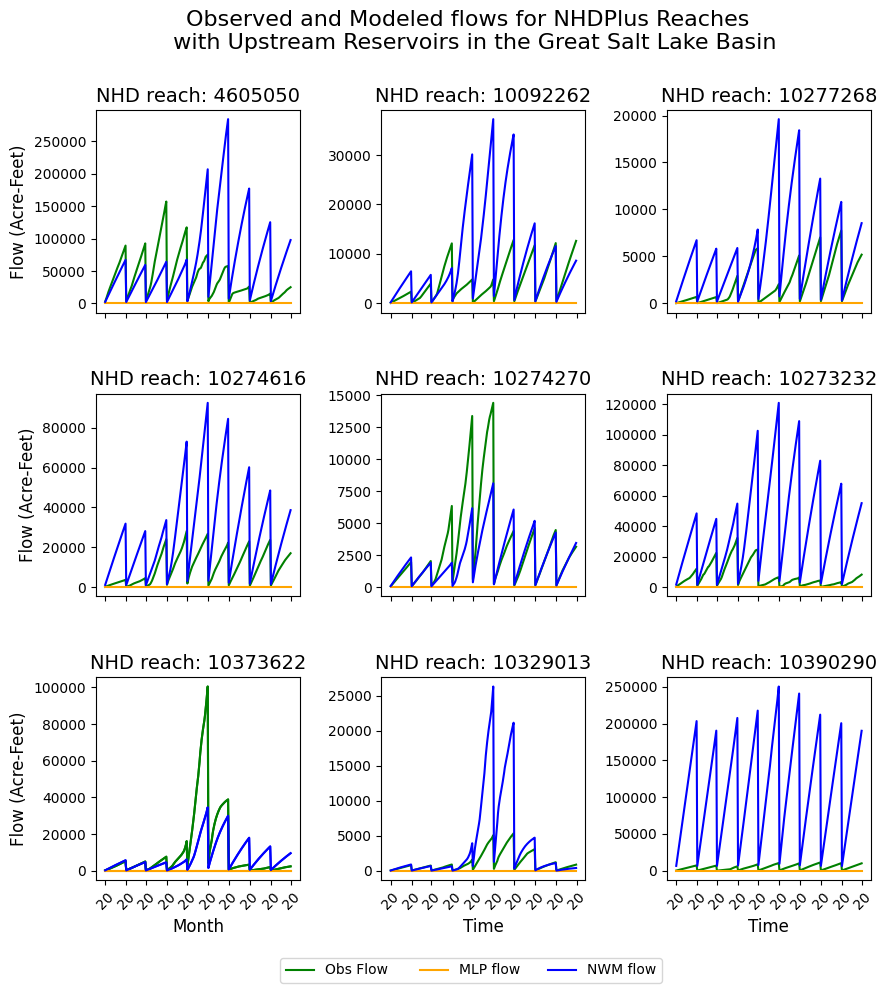

In [44]:
model = 'MLP'
plotname = 'MLP_TS_plot'
freq = 'D'
supply = True
title = 'Observed and Modeled flows for NHDPlus Reaches \n with Upstream Reservoirs in the Great Salt Lake Basin'
TS_plot(SitesDict, model, plotname, title, freq, supply)

In [216]:
import importlib
importlib.reload(FigureGenerator)

<module 'FigureGenerator' from '/home/ec2-user/SageMaker/01.projects/01.ciroh_p8/NWM-ML/savalan/FigureGenerator.py'>

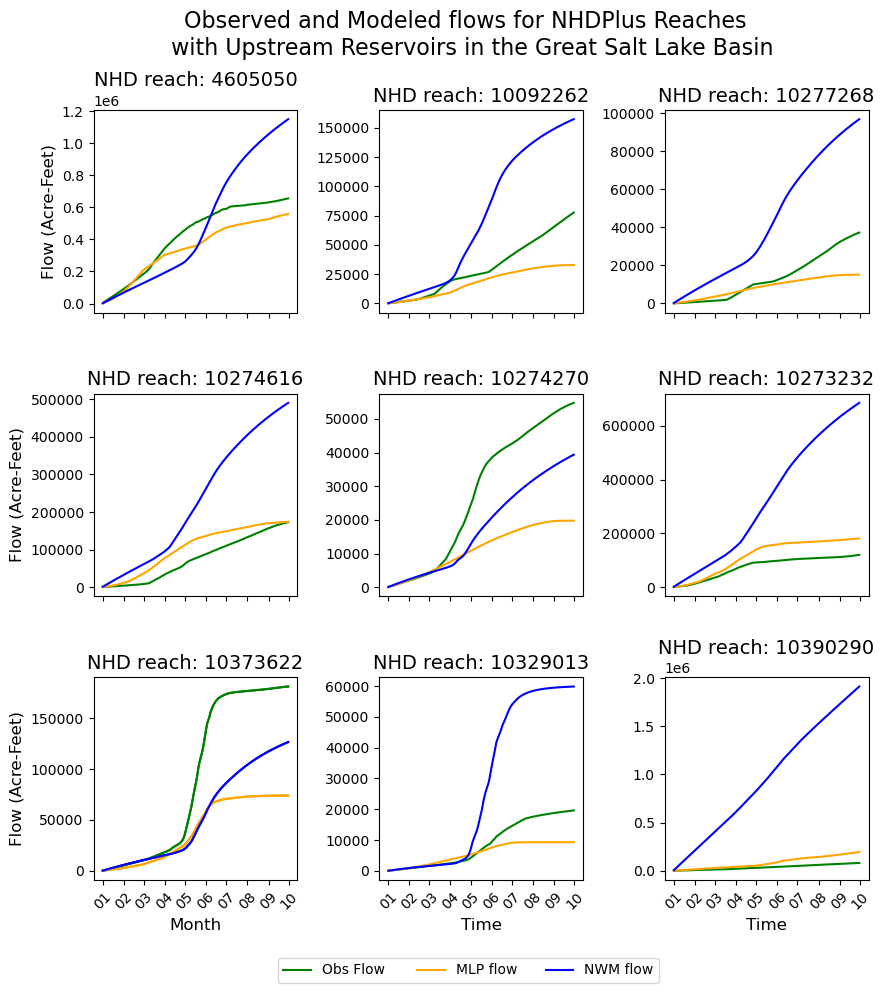

In [227]:
import FigureGenerator

model = 'MLP'
plotname = 'MLP_TS_plot'
freq = 'D'
supply = True
title = 'Observed and Modeled flows for NHDPlus Reaches \n with Upstream Reservoirs in the Great Salt Lake Basin'
FigureGenerator.TS_plot(SitesDict, model, plotname, title, freq, supply)

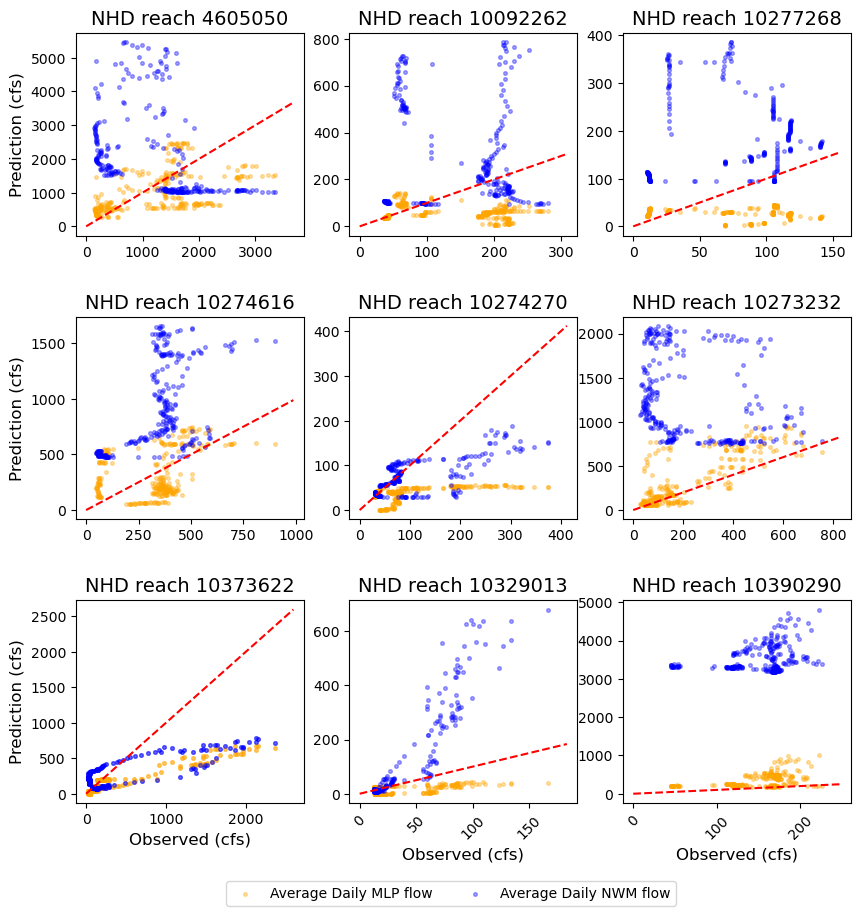

In [160]:
plotname = 'MLP_ParityPlot'
FigureGenerator.Parity_plot(SitesDict, model, plotname)

In [1]:
import AWS_transfer
model = 'MLP'
state = 'ut'
AWS_transfer.Predictions2AWS(model, state)

Pushing files to AWS


100% |########################################################################|


In [54]:
reach = 10273232
variables =['NWM_flow', 'Obs_flow']
colors = ['blue', 'green']
model = 'MLP'
plotname = 'NWMFlow'
units = 'cfs'
y_lab = f"Flow ({units})"
title = f"Daily NWM Estimates \n Reach: {str(reach)}"


FigureGenerator.Var_TS_plot(SitesDict, reach, variables, colors, model,y_lab, plotname, title, units, supply = False)

NameError: name 's_FigureGenerator' is not defined

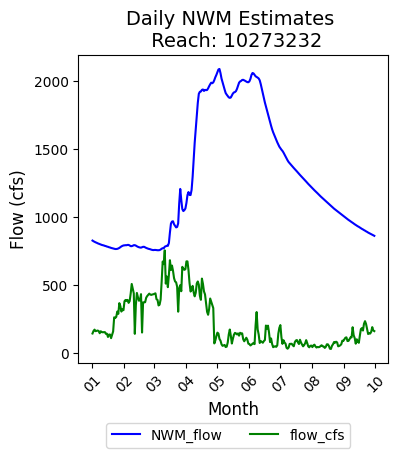

In [57]:
def Var_TS_plot(dictionary, reach, variables, colors, model,ylab, path, title, units, supply = False):
    cfsday_AFday = 1.983
    cols = variables

    #Get keys from dictionary
    RegionDF = dictionary[reach]

    #make figure
    fig, ax = plt.subplots(1,1, figsize=(4, 4))
    

    if supply == True:
        RegionDF = RegionDF*cfsday_AFday
        units = 'Acre-Feet'
        #set up cumulative monthly values
        RegionDF['Year'] = RegionDF.index.year

        #RegionDF = pd.DataFrame(columns=columns)

        for site in cols:
            RegionDF[site] = RegionDF.groupby(['Year'])[site].cumsum()        

    for i in np.arange(0,len(cols), 1):
        ax.plot(RegionDF.index, RegionDF[cols[i]], color = colors[i], label = cols[i])
    ax.xaxis.set_major_locator(MonthLocator())
    ax.xaxis.set_major_formatter(DateFormatter('%m'))

    ax.set_ylabel(ylab, fontsize = 12)
    ax.set_xlabel('Month', fontsize = 12)
    ax.tick_params(axis='x', rotation=45)
    ax.legend( loc = 'lower center', bbox_to_anchor = (0, -0.12, 1, 0),  bbox_transform = plt.gcf().transFigure, ncol = 3)


            
    ax.set_title(title, fontsize = 14)
    plt.savefig(path, dpi = 600, bbox_inches = 'tight')
    plt.show()
reach = 10273232
variables =['NWM_flow', 'flow_cfs']
colors = ['blue', 'green']
model = 'MLP'
plotname = 'NWMFlow'
units = 'cfs'
y_lab = f"Flow ({units})"
title = f"Daily NWM Estimates \n Reach: {str(reach)}"

Var_TS_plot(SitesDict, reach, variables, colors, model,y_lab, plotname, title, units, supply = False)